# Table of Contents
* [Alternate tables](#Alternate-tables)
	* [pairing images and annotations](#pairing-images-and-annotations)
	* [sampling images](#sampling-images)
* [Regents tables](#Regents-tables)
* [Hough lines experiment](#Hough-lines-experiment)
* [End](#End)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import os
import shutil
import cv2
import PIL.Image as Image

# Alternate tables

In [3]:
image_path_prefix = '../data/small_table_training/'
anno_path_prefix = '../data/exp_nicks_data/table-research/ground_truth/alternate/'

image_files = os.listdir(image_path_prefix)
anno_files = os.listdir(anno_path_prefix)

## pairing images and annotations

In [4]:
image_bases = ['.'.join(f.split('.')[:-1]) for f in image_files]
anno_bases = ['.'.join(f.split('.')[:-2]) for f in anno_files]

In [84]:
images_with_anno  = [f  for f in image_files if '.'.join(f.split('.')[:-1]) in anno_bases]

In [85]:
bases_intersection = set(image_bases).intersection(set(anno_bases))

In [86]:
print(len(bases_intersection), len(anno_bases), len(images_with_anno))

97 97 97


images missing annotations

In [83]:
len(image_bases)

146

In [8]:
set(image_bases[:100]).difference(set(anno_bases))

{'029-grid6', '036-table_1(1)', '050-grid15'}

## sampling images

In [9]:
sample_n = 30

In [10]:
sample_image = images_with_anno[sample_n]

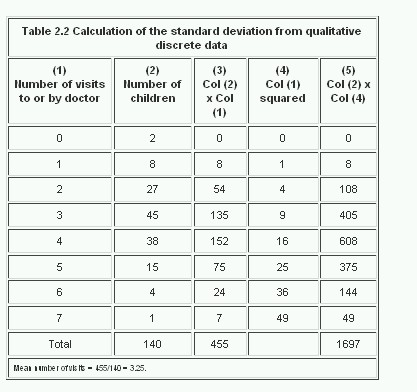

In [11]:
Image.open(image_path_prefix + sample_image)

In [12]:
with open(anno_path_prefix + anno_files[sample_n]) as f:
    sample_anno = f.readlines()

split_lines = [l.split(',', maxsplit=4) for l in sample_anno]

# Regents tables

In [13]:
regents_image_path_prefix = '../data/exp_nicks_data/regents_images/'
regents_anno_path_prefix = '../data/exp_nicks_data/regents_anno/'

In [14]:
regents_anno = os.listdir(regents_anno_path_prefix)

In [15]:
regents_anno_8th = {an: ".PNG" for an in regents_anno if '_8_' in an}
regents_anno_4th = {an: ".PNG" for an in regents_anno if '_4_' in an}
regents_anno_other = {an: an.replace('.jpg.txt', '.png') for an in regents_anno if an not in regents_anno_4th and an not in regents_anno_8th}

In [16]:
# assert(set(regents_anno_other + regents_anno_8th + regents_anno_4th) == set(regents_anno))

In [17]:
regents_images_4 = os.listdir(regents_image_path_prefix + '/4th')
regents_images_8 = os.listdir(regents_image_path_prefix + '/8th')
# regents_images_8 = [ri for ri in regents_anno_other if '2011' in ri]

In [192]:
name_mapping = {
    '2007_4_15.jpg.txt': '2007_4th_Grade_09.PNG',
    '2009_4_31b.jpg.txt': '2009_4th_Grade_11.PNG',
    '2009_4_40.jpg.txt': '2009_4th_Grade_18.PNG',
    '2011_4_32.jpg.txt': '2011_4th_Grade_16.PNG',
    
    
    '2004_8_55_2.jpg.txt': '2004_8th_Grade_53.PNG',
    '2004_8_64-65.jpg.txt': '2004_8th_Grade_55.PNG',
    '2005_8_38.jpg.txt': '2005_8th_Grade_26.PNG',
    '2005_8_46-48.jpg.txt': '2005_8th_Grade_29.PNG',
    '2005_8_79.jpg.txt': '2005_8th_Grade_44.PNG',
    '2007_8_49-50.jpg.txt': '2007_8th_Grade_20.PNG',
    '2007_8_60.jpg.txt': '2007_8th_Grade_27.PNG',
    '2009_8_33.jpg.txt': '2009_8th_Grade_16.PNG',
    '2009_8_79-81.jpg.txt': '2009_8th_Grade_41.PNG',
    '2009_8_82-83b.jpg.txt': '2009_8th_Grade_43.PNG',
    '2011_8_56.jpg.txt': '2011_8th_Grade_33.PNG',
    '2011_8_79-80.jpg.txt': '2011_8th_Grade_46.PNG',
    
    '2007-01-24_12_54-56.jpg.txt': '2007-01-24_12_54-56.png',
    '2007-01-24_12_77-79.jpg.txt': '2007-01-24_12_77-79.png',
    '2007-08-16_12_16_3.jpg.txt': '2007-08-16_12_16_3.png', 
    '2007-08-16_12_20.jpg.txt': '2007-08-16_12_20.png',
    '2007-08-16_12_75-77.jpg.txt': '2007-08-16_12_75-77.png',
    '2009-01-28_12_13_1.jpg.txt': '2009-01-28_12_13_1.png',
    '2009-01-28_12_13_4.jpg.txt': '2009-01-28_12_13_4.png',
    '2009-01-28_12_71-74.jpg.txt': '2009-01-28_12_71-74.png',
    '2009-06-17_12_13.jpg.txt': '2009-06-17_12_13.png',
    '2009-06-17_12_33_2.jpg.txt': '2009-06-17_12_33_2.png',
    '2009-06-17_12_34.jpg.txt': '2009-06-17_12_34.png',
    '2009-06-17_12_54-57.jpg.txt': '2009-06-17_12_54-57.png',
    '2009-08-13_12_35_1.jpg.txt': '2009-08-13_12_35_1.png',
    '2009-08-13_12_35_4.jpg.txt': '2009-08-13_12_35_4.png',
    '2009-08-13_12_45-47.jpg.txt': '2009-08-13_12_45-47.png',
    '2011-06-17_12_36-40.jpg.txt': '2011-06-17_12_36-40.png',
    '2011-06-17_12_47-50.jpg.txt': '2011-06-17_12_47-50.png'
}

In [19]:
# with open('image_anno_mapping.json', 'w') as f:
#     json.dump(name_mapping, f)

# Build new dataset

In [64]:
import ai2.vision.utils as ai2vu

In [65]:
new_data_dir = '/Users/schwenk/wrk/tableparse/data/test_data/'
regents_path_prefix = '/Users/schwenk/wrk/tableparse/data/exp_nicks_data/regents_images/all_images/'

In [74]:
def read_image_anno(img_f, anno_f=None):
    if not anno_f:
        ann_ext = '.jpg.txt'
        anno_f = anno_path_prefix + os.path.splitext(fb)[0]  + ann_ext
    with open(anno_f) as f:
        sample_anno = f.readlines()
    split_lines = [l.split(',', maxsplit=4) for l in sample_anno]
    build_image_anno = [{'text': line[-1].strip() , 'rectangle': list(map(int, line[:4]))} for line in split_lines]
    image_number = str(img_counter).zfill(3)
    new_img_name = 'table_' + image_number + '.png'
    image_anno = {
        'annotations': build_image_anno,
        'imageName': new_img_name,
        'tableID': 'T_' + image_number,
        'legacyName': os.path.split(fb)[1],
    }
    return {image_anno['tableID']: image_anno}, new_img_name

In [201]:
img_counter = 0
image_annotations = {}

building image annotations and standardizing images

In [ ]:
for fb in images_with_anno:
    img_counter += 1
    img_f = image_path_prefix + fb
    img_anno, new_img_name = read_image_anno(img_f)
    image_annotations.update(img_anno)
    new_img = new_data_dir + 'images/' + new_img_name
    standardized_img, _ = ai2vu.standardize_images.standardize_image(img_f)
    cv2.imwrite(new_img, standardized_img)

for anno_file, img_file in name_mapping.items():
    img_counter += 1
    img_f = regents_path_prefix + img_file
    img_anno, new_img_name = read_image_anno(img_f)
    image_annotations.update(img_anno)
    new_img = new_data_dir + 'images/' + new_img_name
    standardized_img, _ = ai2vu.standardize_images.standardize_image(img_f)
    cv2.imwrite(new_img, standardized_img)

In [203]:
def random_color():
    import random
    return random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)

def draw_detections(gt_anno):    
    image = cv2.imread(new_data_dir + 'images/' + gt_anno['imageName'])
    color_counter = 0
    for cell in gt_anno['annotations']:
        cell = cell['rectangle']
        start_x = cell[0] 
        start_y = cell[1]
        end_x = cell[0] + cell[2]
        end_y = cell[1] + cell[3]
        cv2.rectangle(image, (start_x, start_y), (end_x, end_y), color=random_color(), thickness=2)
        color_counter += 1
    return Image.fromarray(image)

In [215]:
with open(new_data_dir + 'table_ground_truth.json', 'w') as f:
    json.dump(image_annotations, f, sort_keys=True, indent=4)

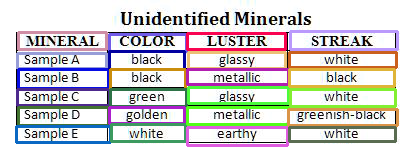

In [221]:
test_anno = image_annotations['T_050']
draw_detections(test_anno)

## looking at resized images

In [196]:
def get_max_dim(img_anno):
    boxes = [(box['rectangle'][0] + box['rectangle'][2], box['rectangle'][1] + box['rectangle'][3]) for box in list(img_anno.values())[0]['annotations']]
    xs, ys = list(zip(*boxes))
    max_x = max(xs)
    max_y = max(ys)
    return max_x, max_y

In [205]:
img_counter = 0

In [206]:
for fb in images_with_anno:
    img_counter += 1
    img_f = image_path_prefix + fb
    img_anno, new_img_name = read_image_anno(img_f)
    max_x, max_y = get_max_dim(img_anno)
    image_shape = Image.open(img_f).size
    new_img = new_data_dir + 'images/' + new_img_name
    standardized_img, _ = ai2vu.standardize_images.standardize_image(img_f)
    resized_shape = standardized_img.shape[:2][::-1]
    if image_shape != resized_shape:
        print(img_counter, image_shape, resized_shape)

51 (1615, 788) (1500, 731)


In [210]:
for anno_file, img_file in name_mapping.items():
    img_counter += 1
    img_f = regents_path_prefix + img_file
    img_anno, new_img_name = read_image_anno(img_f)
    max_x, max_y = get_max_dim(img_anno)
    image_shape = Image.open(img_f).size
    new_img = new_data_dir + 'images/' + new_img_name
    standardized_img, _ = ai2vu.standardize_images.standardize_image(img_f)
    resized_shape = standardized_img.shape[:2][::-1]
    if image_shape != resized_shape:
        print(img_counter, image_shape, resized_shape)

124 (1554, 353) (1500, 340)
130 (1510, 722) (1500, 717)


# Hough lines experiment

In [15]:
easy_image = '/Users/schwenk/wrk/tableparse/vision-tableparse/examples/example_1.png'

# img = cv2.imread(image_path_prefix + sample_image)
img = cv2.imread(easy_image)

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


edges = cv2.Canny(gray, 100, 200, apertureSize=3, L2gradient=1)

minLineLength = 30
maxLineGap = 10
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 120, minLineLength=10, maxLineGap=2)
for x in range(0, len(lines)):
    for x1,y1,x2,y2 in lines[x]:
        cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

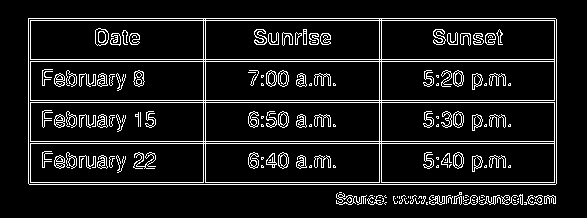

In [4]:
Image.fromarray(edges)

In [8]:
# You need to choose 4 or 8 for connectivity type
connectivity = 4
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# Perform the operation
output = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)

In [14]:
output[]

array([[   29,    18,   527,   186,  8784],
       [    0,     0,   587,   218, 40288],
       [   30,    20,   174,    40,  6554],
       [  205,    20,   175,    40,  6512],
       [  381,    20,   174,    40,  6489],
       [   99,    32,     7,    11,    62],
       [  132,    35,     5,     3,    10],
       [  323,    35,     5,     3,    10],
       [  488,    35,     5,     3,    11],
       [  113,    39,     5,     4,    11],
       [   30,    61,   174,    40,  6349],
       [  205,    61,   175,    40,  6530],
       [  381,    61,   174,    40,  6503],
       [  136,    73,     6,     4,    20],
       [  268,    73,     7,    11,    64],
       [  280,    73,     7,    11,    64],
       [  455,    73,     7,    11,    65],
       [   57,    76,     6,     4,    22],
       [   69,    76,     6,     8,    44],
       [  474,    76,     6,     8,    44],
       [  136,    79,     6,     5,    27],
       [   99,    80,     6,     5,    19],
       [  298,    80,     6,    

In [24]:
lines.shape

(18, 1, 4)

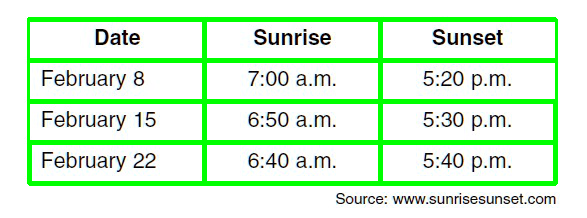

In [25]:
Image.fromarray(img)

In [26]:
import cv2
import numpy as np
import os.path
from collections import defaultdict


def ik(x, y):
    return '.'.join([str(x), str(y)])


def boxes_from_intersections(image_bw, h_intersections, v_intersections, all_intersections):
    boxes = []
    for x_i, y_i in all_intersections:
        i_key = ik(x_i, y_i)
        nearest_y = 99999999
        nearest_x = 99999999
        found_point = False
        for x_j, y_j in all_intersections:
            j_key = ik(x_j, y_j)
            if x_j > x_i and y_j > y_i and (h_intersections[i_key] & v_intersections[j_key]) and \
               (v_intersections[i_key] & h_intersections[j_key]) and x_j <= nearest_x and y_j <= nearest_y:
                nearest_x = x_j
                nearest_y = y_j
                found_point = True

        if found_point:
            # x, y, width, height, text
            height = nearest_y - y_i
            width = nearest_x - x_i
            avg_color = (np.average(image_bw[y_i:nearest_y, x_i:nearest_x]))
            if (width <= 15 or height <= 15) and avg_color == 0.0:
                continue
            boxes.append((x_i, y_i, width, height, []))

    return boxes


def get_intersections(img, horiz_lines, vert_lines):
    h_intersections = defaultdict(set)
    v_intersections = defaultdict(set)
    all_intersections = set()

    for h_x1, h_y1, h_x2, h_y2 in horiz_lines:
        intersect_set = set()
        for v_x1, v_y1, v_x2, v_y2 in vert_lines:
            if v_x1 >= h_x1 and v_x1 <= h_x2 and v_y1 <= h_y1 and v_y2 >= h_y1:
                i_key = ik(v_x1, h_y1)
                intersect_set.add(i_key)

        if len(intersect_set) > 2:
            for s in intersect_set:
                all_intersections.add(tuple(map(int, s.split('.'))))
                h_intersections[s] = intersect_set

    for v_x1, v_y1, v_x2, v_y2 in vert_lines:
        intersect_set = set()
        for h_x1, h_y1, h_x2, h_y2 in horiz_lines:
            if v_x1 >= h_x1 and v_x1 <= h_x2 and v_y1 <= h_y1 and v_y2 >= h_y1:
                i_key = ik(v_x1, h_y1)
                intersect_set.add(i_key)

        if len(intersect_set) > 2:
            for s in intersect_set:
                all_intersections.add(tuple(map(int, s.split('.'))))
                v_intersections[s] = intersect_set

    return h_intersections, v_intersections, list(all_intersections)

def supress_lines(lines):
    new_lines = []
    for i, line_a in enumerate(lines):
        suppressed = False
        for j, line_b in enumerate(lines):
            if i >= j:
                continue

            if line_a[0] == line_a[2]:
                min_x = min([line_a[1], line_b[1]])
                max_x = max([line_a[3], line_b[3]])
                intersection = min([line_a[3], line_b[3]]) - max([line_a[1], line_b[1]])
                delta = abs(line_a[0] - line_b[0])

            else:
                min_x = min([line_a[0], line_b[0]])
                max_x = max([line_a[2], line_b[2]])
                intersection = min([line_a[2], line_b[2]]) - max([line_a[0], line_b[0]])
                delta = abs(line_a[1] - line_b[1])

            if intersection > 0 and (intersection/float(max_x - min_x)) > 0.5 and delta < 8:
                suppressed = True
                break

        if not suppressed:
            new_lines.append(line_a)

    return new_lines

In [27]:
def get_boxes(image_name, base_path):
    horiz_lines = []
    vert_lines = []
    img = cv2.imread(os.path.join(base_path, image_name))
    #img =  cv2.resize(img,(2*img.shape[1], 2*img.shape[0]), interpolation = cv2.INTER_CUBIC)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    (thresh, im_bw) = cv2.threshold(gray, 128, 255, cv2.THRESH_OTSU)

    edges = cv2.Canny(gray, 50, 250, apertureSize=3)
#     edges = cv2.Canny(gray, 100, 200, apertureSize=3, L2gradient=1)
#     return Image.fromarray(edges)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 200, minLineLength=20, maxLineGap=3)
#     lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 120, minLineLength=100, maxLineGap=2)
    if lines is None:
        lines = []

    for info in lines:
        x1, y1, x2, y2 = info[0]
        if y2 < y1:
            y1 = info[0][3]
            y2 = info[0][1]

        # horizontal line
        offsets = [-1, 0, 1]
        if y1 - y2 == 0:
            avg_above = avg_below = 256
            avg_center = np.average(gray[y1:y2 + 1, x1:x2 + 1])

            if y1 > 0:
                avg_above = np.average(gray[y1 - 1:y2, x1:x2 + 1])

            if y2 + 1 < gray.shape[0]:
                avg_below = np.average(gray[y1 + 1:y2 + 2, x1:x2 + 1])

            # assuming black lines, could do something to check for background color

            # this occurs from edges detected in gray areas that aren't cell boundaries
            if np.min([avg_above, avg_center, avg_below]) > 192:
                continue

            y1 += offsets[np.argmin([avg_above, avg_center, avg_below])]

            y2 = y1

            while x2 + 1 < im_bw.shape[1] and abs(im_bw[y1:y2 + 1, x2 + 1:x2 + 2][0,0] - np.average(im_bw[y1:y2 + 1, x1:x2 + 1])) < 16:
                x2 += 1

            while x1 > 0 and abs(im_bw[y1:y2 + 1, x1 - 1:x1][0,0] - np.average(im_bw[y1:y2 + 1, x1:x2 + 1])) < 16:
                x1 -= 1

            horiz_lines.append((x1, y1, x2, y2))
        elif x1 - x2 == 0:
            avg_right = avg_left = 256
            avg_center = np.average(gray[y1:y2 + 1, x1:x2 + 1])

            if x1 > 0:
                avg_left = np.average(gray[y1:y2 + 1, x1 - 1:x2])

            if x2 + 1 < gray.shape[1]:
                avg_right = np.average(gray[y1:y2 + 1, x1 + 1: x2 + 2])

            x1 += offsets[np.argmin([avg_left, avg_center, avg_right])]

            x2 = x1

            while y2 + 1 < im_bw.shape[0] and abs(im_bw[y2 + 1:y2 + 2, x1:x2 + 1][0,0] - np.average(im_bw[y1:y2 + 1, x1:x2 + 1])) < 16:
                y2 += 1

            while y1 > 0 and abs(im_bw[y1 - 1:y1, x1:x2 + 1][0,0] - np.average(im_bw[y1:y2 + 1, x1:x2 + 1])) < 16:
                y1 -= 1

            vert_lines.append((x1, y1, x2, y2))
    horiz_lines = supress_lines(horiz_lines)
    vert_lines = supress_lines(vert_lines)

    sorted_h_lines = sorted(horiz_lines, key=lambda l: l[1])
    sorted_v_lines = sorted(vert_lines, key=lambda l: l[0])
    h_intersections, v_intersections, all_intersections = get_intersections(img, sorted_h_lines, sorted_v_lines)
    return boxes_from_intersections(im_bw, h_intersections, v_intersections, all_intersections)

In [28]:
def random_color():
    import random
    return random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)

def draw_detections(img_path, found_cells):
    colors = [
        (255, 0, 0),
        (0, 255, 0),
        (0, 0, 255),
        (255, 255, 0),
        (0, 255, 255),
        (255, 0, 255),

        (128, 0, 0),
        (0, 128, 0),
        (0, 0, 128),
        (128, 128, 0),
        (0, 128, 128),
        (128, 0, 128),

        (255, 128, 0),
        (0, 128, 255),
        (128, 255, 0),
        (0, 255, 128),
        (255, 0, 128),
        (128, 0, 255)]
    
    image = cv2.imread(img_path)
    color_counter = 0
    for cell in found_cells:
        start_x = cell[0] 
        start_y = cell[1]
        end_x = cell[0] + cell[2]
        end_y = cell[1] + cell[3]
        cv2.rectangle(image, (start_x, start_y), (end_x, end_y), color=random_color(), thickness=2)
        color_counter += 1
    return Image.fromarray(image)

In [29]:
old_boxes = get_boxes(sample_image, image_path_prefix)

In [30]:
new_boxes = get_boxes(sample_image, image_path_prefix)

In [31]:
len(new_boxes)

28

In [32]:
import random

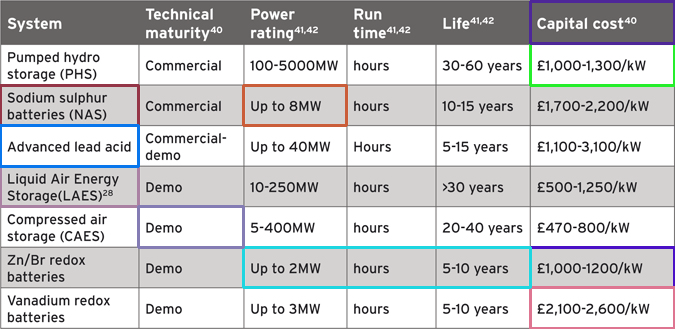

In [34]:
draw_detections(image_path_prefix + sample_image, random.sample(new_boxes, 10))

# End

In [382]:
# img_n = 0

# anno_n = 0

# # img_n +=1
# # print(regents_images_8[img_n])
# # Image.open(regents_image_path_prefix + '/8th/' + regents_images_8[img_n])

# # anno_n += 1
# # with open(regents_anno_path_prefix + list(regents_anno_other.keys())[anno_n]) as f:
# #     print(list(regents_anno_other.keys())[anno_n])
# #     print()
# #     print(f.read())

# # anno_n += 1
# # with open(regents_anno_path_prefix + list(regents_anno_other.keys())[anno_n]) as f:
# #     print(list(regents_anno_other.keys())[anno_n])
# #     print()
# #     print(f.read())